# Pipeline for BIAPT lab EEG Preprocessing: 
#### inspired by: https://github.com/hoechenberger/pybrain_mne/
#### adapted by: Beatrice PDK, Victoria Sus and Charlotte Maschke, 
#### This pipeline uses MNE Python to preprocess EEG data: Plese go here: 
####                                https://mne.tools/stable/overview/index.html
####  for more documentation on MNE Python

## Setup and import

In [1]:
import matplotlib
#import mne_bids
import pathlib
import mne
import os
import os.path as op
from mne import viz
import numpy as np

# interactive plotting functions.


from mne.preprocessing import (ICA, create_eog_epochs, create_ecg_epochs,corrmap)
#import openneuro

#from mne_bids import BIDSPath, read_raw_bids, print_dir_tree, make_report

# Ensure Matplotlib uses the Qt5Agg backend, 
# which is the best choice for MNE-Python's 
# interactive plotting functions.
matplotlib.use('Qt5Agg')

import matplotlib.pyplot as plt

### Enter the recording information you want preprocess

In [47]:
ID = "022MW"
task = "Turn1"

location = 'SOURCE-NET-ICU'
output = 'continuous_derivative_NET-ICU'
extension = 'mff'


#location = 'NET-ICU-sourcedata'


In [48]:
raw_path = f"DATA/{location}/sub-{ID}/eeg/sub-{ID}_task-{task}_eeg.{extension}"
raw_path

'DATA/SOURCE-NET-ICU/sub-022MW/eeg/sub-022MW_task-Turn1_eeg.mff'

## Load the raw data!

In [49]:
if extension == 'mff':
    raw = mne.io.read_raw_egi(raw_path)
if extension == 'set':
    raw = mne.io.read_raw_eeglab(raw_path)
raw

Reading EGI MFF Header from /Users/charlotte/Documents/GitHub/dynamic_reconfiguration/DATA/SOURCE-NET-ICU/sub-022MW/eeg/sub-022MW_task-Turn1_eeg.mff...
    Reading events ...
    Assembling measurement info ...
    Synthesizing trigger channel "STI 014" ...
    Excluding events {sync} ...


/var/folders/jt/1njpx4d93pn5y3nd0p7l5hwr0000gn/T/ipykernel_3882/3708346446.py:2: RuntimeWarning: Did not find any event code with more than one event.
  raw = mne.io.read_raw_egi(raw_path)


<RawMff | signal1.bin, 132 x 1807186 (1807.2 s), ~181 kB, data not loaded>

## Resample the data to 250

In [50]:
if raw.info['sfreq'] != 250:
    raw = raw.resample(250)

1 events found
Event IDs: [1]
1 events found
Event IDs: [1]


### Keep the EEG only

In [51]:
# this is to load EEG. If you want to load other stuff please refer to the website documentation
eeg = raw.pick_types(eeg = True)
print('Number of channels in EEG:')
len(eeg.ch_names)

Number of channels in EEG:


129

## Apply filtering

In [52]:
# load actual data into system (before it was only metadata)
eeg.load_data()
#eeg.load_data()

# filter the data between 0.1 to 55 Hz
eeg_filtered = eeg.filter(l_freq=0.1, h_freq = 55)

# notch filter the data for freq =60
eeg_notch = eeg_filtered.copy().notch_filter(freqs= 60)
#eeg_notch = eeg_notch.copy().notch_filter(freqs= 50)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.1 - 55 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.10
- Lower transition bandwidth: 0.10 Hz (-6 dB cutoff frequency: 0.05 Hz)
- Upper passband edge: 55.00 Hz
- Upper transition bandwidth: 13.75 Hz (-6 dB cutoff frequency: 61.88 Hz)
- Filter length: 8251 samples (33.004 sec)

Setting up band-stop filter from 59 - 61 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 59.35
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 59.10 Hz)
- Upper passband edge: 60.65 Hz
- Upper transition bandwid

In [53]:
%matplotlib qt
viz.plot_raw_psd(eeg_notch, exclude = ['E129'], fmax = 70)
if not os.path.exists('./Preprocessing/sub-{}'.format(ID,task)) :
    os.makedirs('./Preprocessing/sub-{}'.format(ID,task))
plt.savefig('./Preprocessing/sub-{}/sub-{}_task-{}_PSD_raw_filtered.png'.
            format(ID,ID,task))

Effective window size : 8.192 (s)


## Crop the data

Depending on the data, we may need to crop the begining or/and the end <br>
Select if begining and end should be cropped and adapt next line accordingly

In [ ]:
#eeg_cropped= eeg_notch.crop(tmin=4.0,tmax=401.0)
#eeg_cropped.plot(duration=10, n_channels=120,title='cropped')

In [54]:
eeg_cropped = eeg_notch.copy()

## Visualize raw data to identify bad channels

Opening raw-browser...


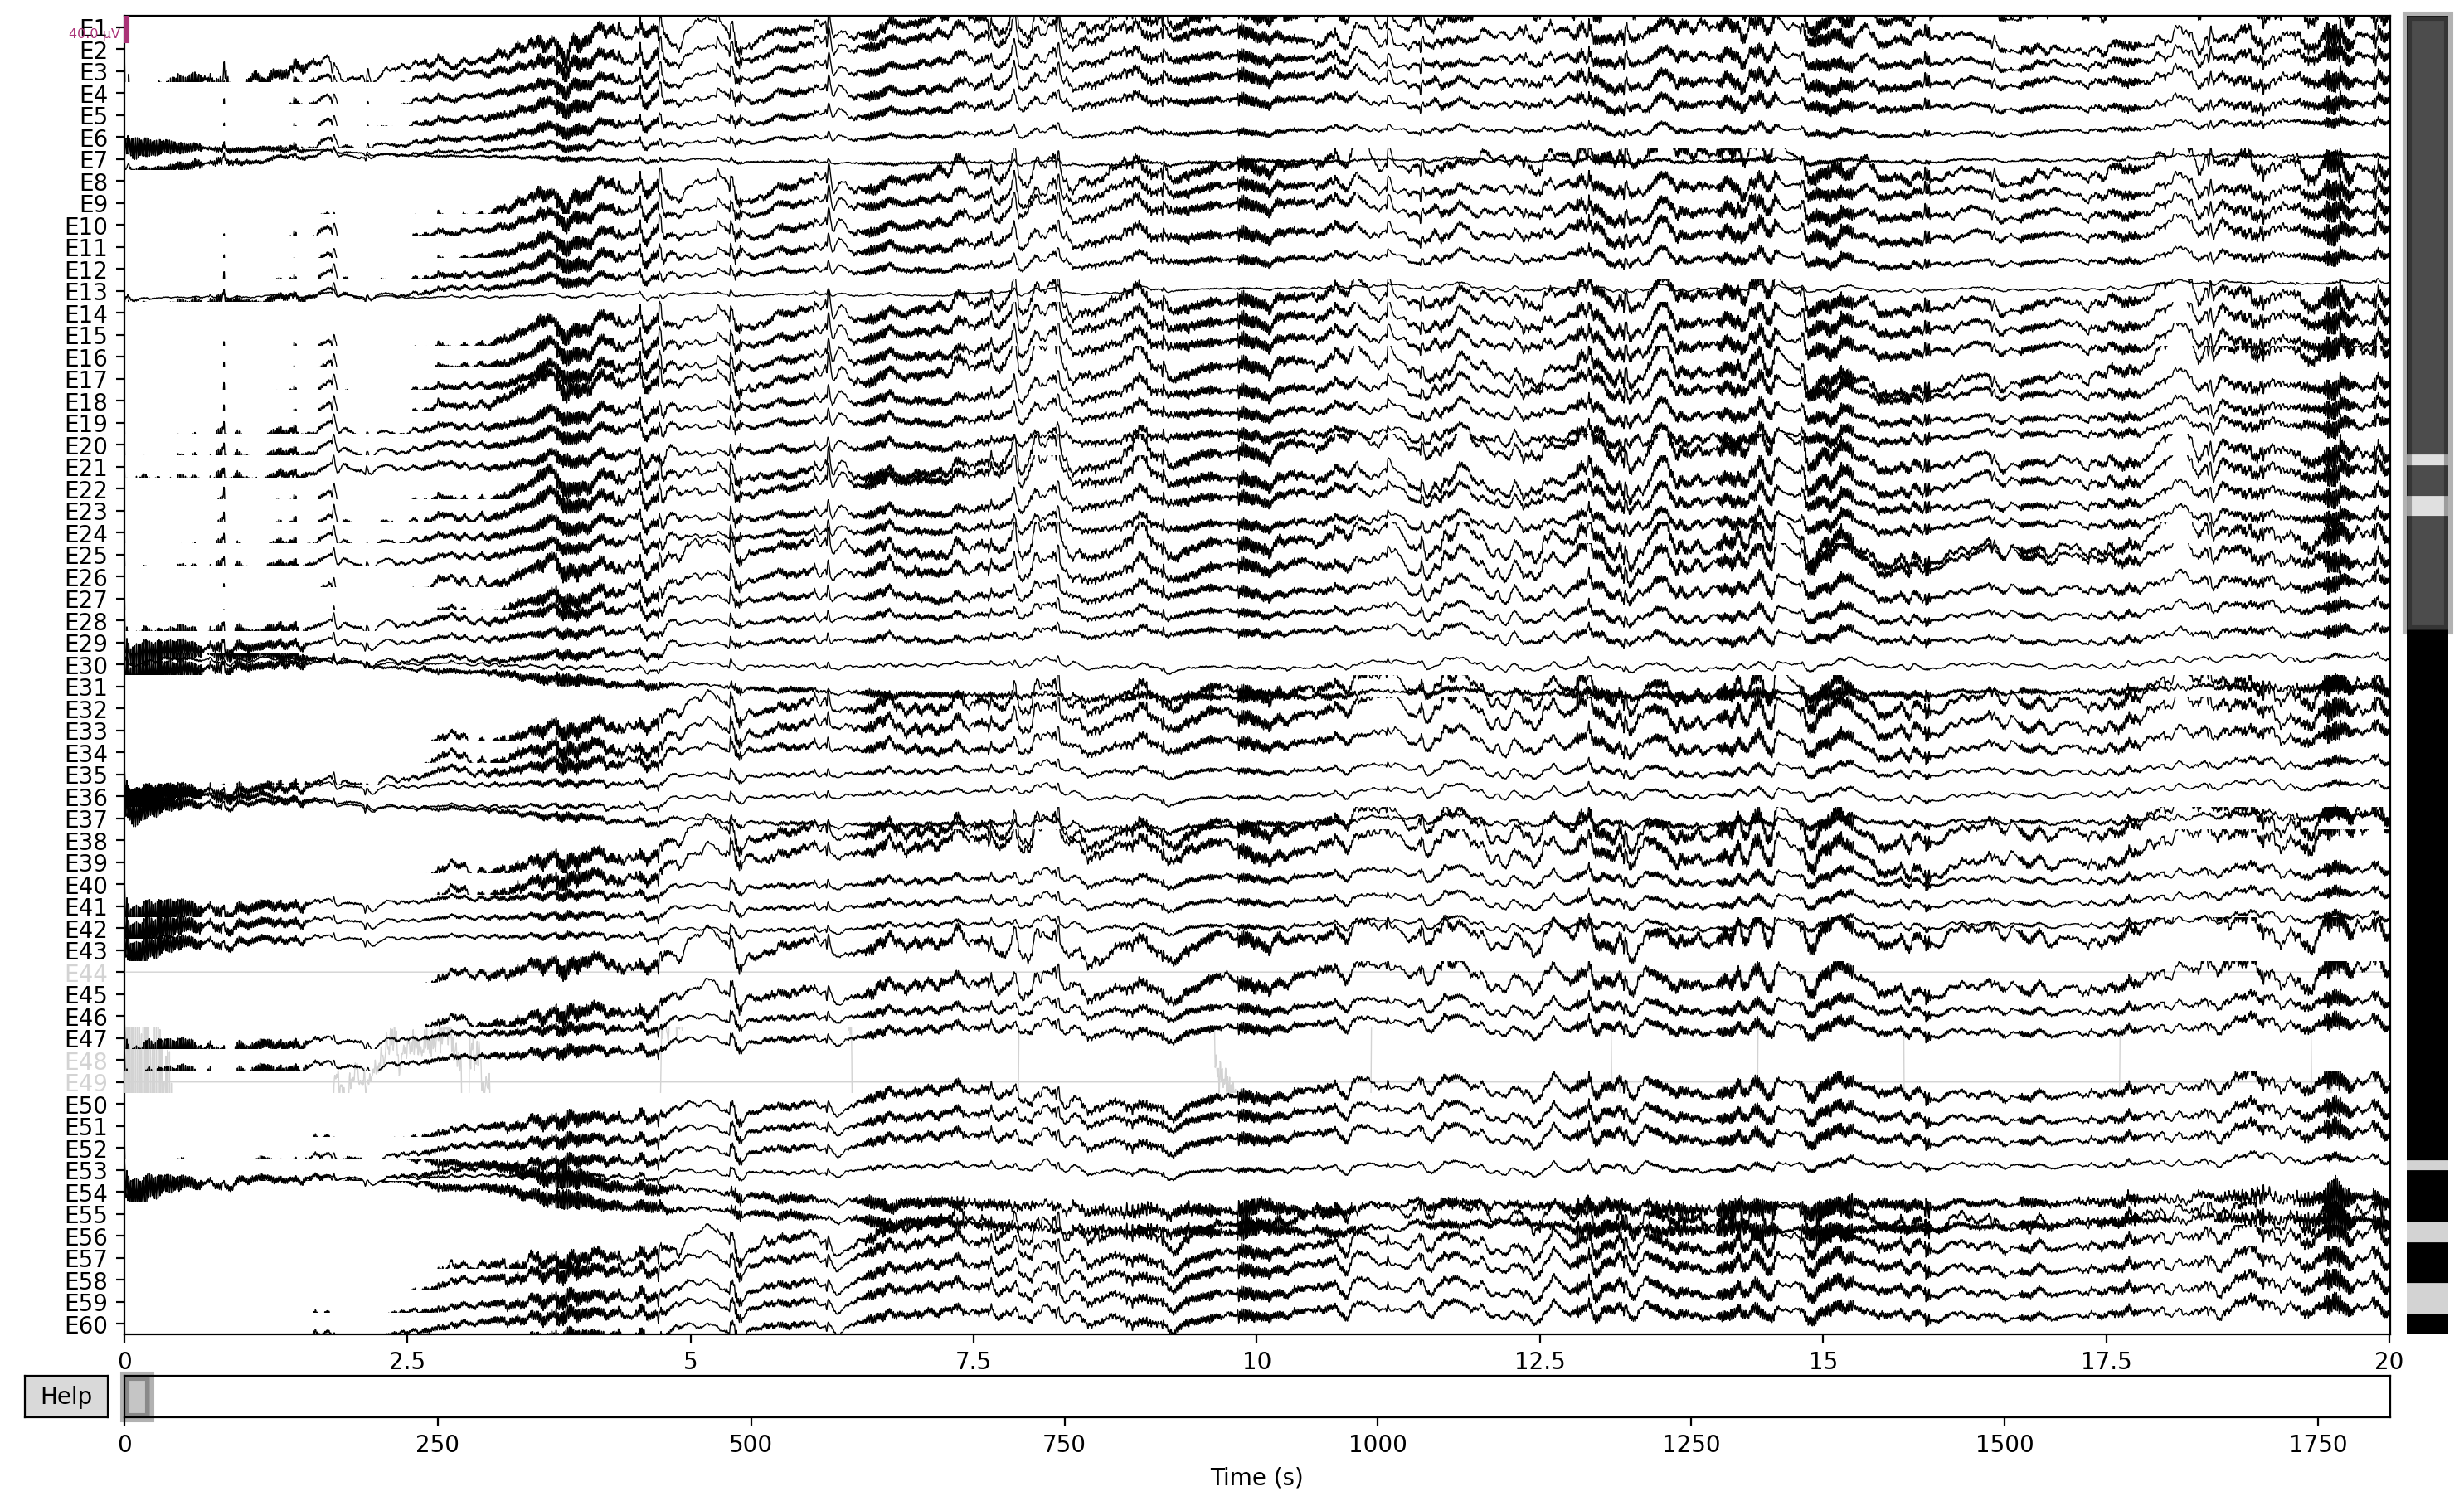

Closing raw-browser...
Channels marked as bad:
['E48', 'E113', 'E119', 'E127', 'E126', 'E125', 'E120', 'E49', 'E44', 'E54']


In [81]:
eeg_cropped.plot(n_channels=60, duration=20)

Verify if labelled correctly

In [82]:
marked_bad = eeg_cropped.info['bads']
marked_bad

['E48', 'E113', 'E119', 'E127', 'E126', 'E125', 'E120', 'E49', 'E44', 'E54']

In [63]:
#eeg_cropped.plot(n_channels =30, duration=20)

In [83]:
# save in a txt
if not os.path.exists('./Preprocessing/sub-{}'.format(ID)) :
    os.makedirs('./Preprocessing/sub-{}'.format(ID))
with open('./Preprocessing/sub-{}/sub-{}_task-{}_marked_bads.txt'.format(ID,ID,task), 'w') as outfile:
    outfile.write("\n".join(marked_bad))


In [84]:
# just for plotting reasons, we add E129 here. This does not add E129 to the bad channels
bads = eeg_cropped.info['bads'].copy()
bads.append('E129')

Effective window size : 8.192 (s)


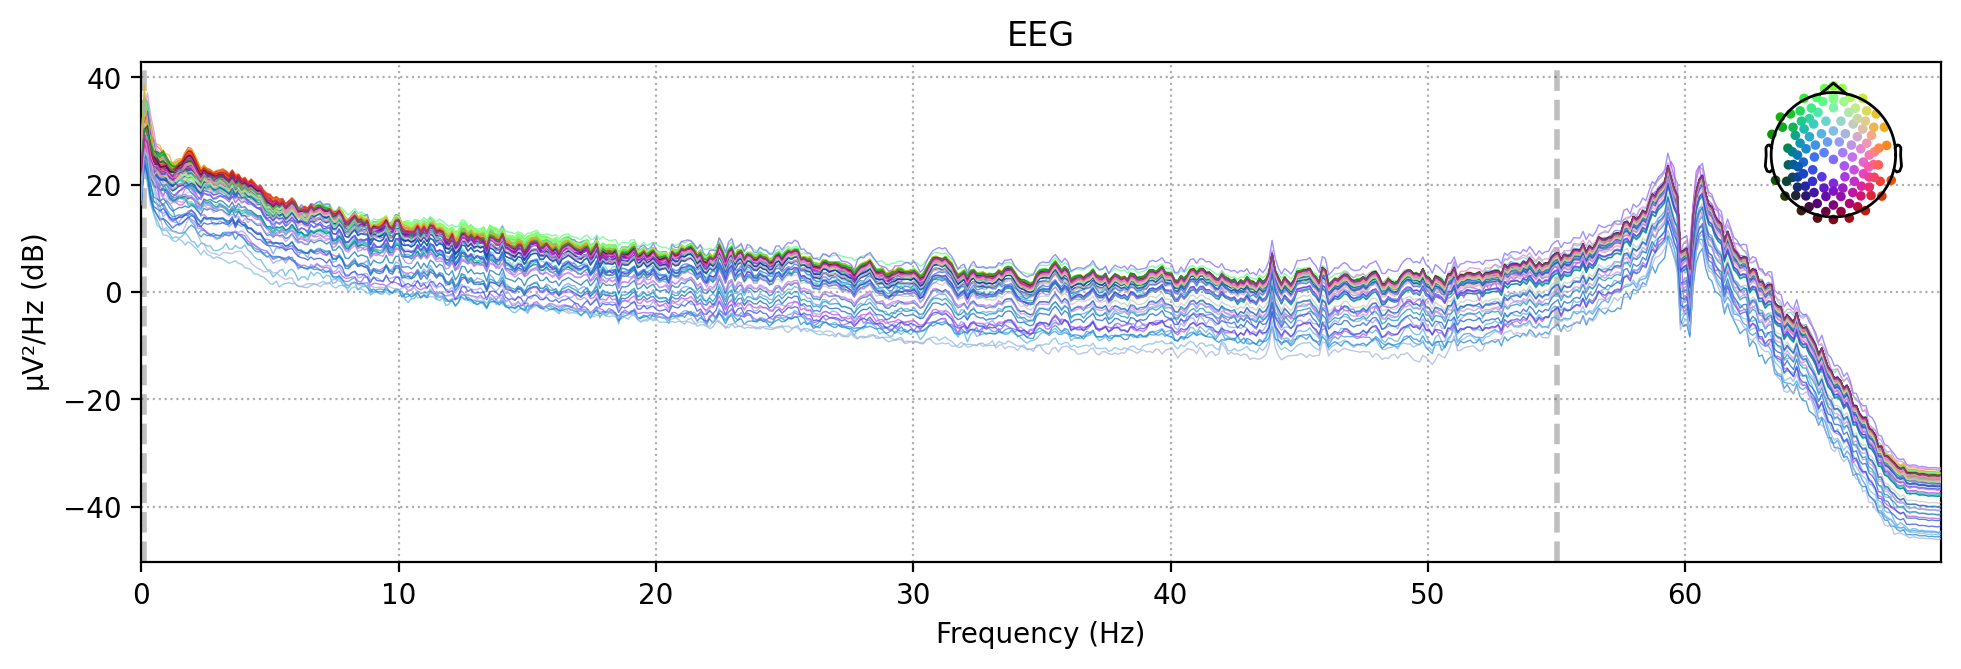

In [85]:
%matplotlib qt
viz.plot_raw_psd(eeg_cropped, exclude = bads, fmax = 70)

## Remove bad channels

In [86]:
eeg_cropped_removed = eeg_cropped.copy().drop_channels(eeg_cropped.info['bads'])

In [ ]:
# in case we want to look at it again
#eeg_cropped_removed.plot(n_channels =60, duration=20)

## Segment into 10-sec epochs

In [87]:
epochs = mne.make_fixed_length_epochs(eeg_cropped_removed, duration = 10, overlap=0)

Not setting metadata
180 matching events found
No baseline correction applied
0 projection items activated


In [88]:
epochs  #verify initial number

<Epochs |  180 events (good & bad), 0 - 9.996 sec, baseline off, ~169 kB, data not loaded,
 '1': 180>

### Reject epochs with amplitude bigger than 2000 µVolt 

Peak to peak amplitude on brain scalp > 2000 µVolt are epochs not linked with physiological causes, physiological amplitude accepted < 800 µVolt

Using data from preloaded Raw for 180 events and 2500 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['E18', 'E22', 'E23']
    Rejecting  epoch based on EEG : ['E22']
    Rejecting  epoch based on EEG : ['E121']
    Rejecting  epoch based on EEG : ['E1', 'E2', 'E3', 'E4', 'E5', 'E8', 'E9', 'E10', 'E11', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E25', 'E26', 'E27', 'E31', 'E32', 'E33', 'E34', 'E38', 'E39', 'E43', 'E45', 'E50', 'E51', 'E52', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E62', 'E63', 'E64', 'E65', 'E66', 'E67', 'E68', 'E69', 'E70', 'E71', 'E72', 'E73', 'E74', 'E75', 'E76', 'E77', 'E81', 'E82', 'E83', 'E84', 'E85', 'E88', 'E89', 'E90', 'E91', 'E92', 'E93', 'E94', 'E95', 'E96', 'E97', 'E98', 'E99', 'E100', 'E101', 'E102', 'E103', 'E104', 'E107', 'E108', 'E109', 'E110', 'E111', 'E114', 'E115', 'E116', 'E117', 'E121', 'E122', 'E123', 'E124', 'E128']
    Rejecting  epoch based on EEG : ['E1', 'E2', 'E4', 'E8', 'E10',

    Rejecting  epoch based on EEG : ['E55']
    Rejecting  epoch based on EEG : ['E1', 'E2', 'E4', 'E8', 'E9', 'E10', 'E11', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E23', 'E25', 'E26', 'E31', 'E32', 'E33', 'E34', 'E37', 'E38', 'E39', 'E43', 'E45', 'E50', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E62', 'E63', 'E64', 'E65', 'E66', 'E67', 'E68', 'E69', 'E70', 'E71', 'E72', 'E73', 'E74', 'E75', 'E76', 'E77', 'E81', 'E82', 'E83', 'E84', 'E85', 'E88', 'E89', 'E90', 'E91', 'E92', 'E94', 'E95', 'E96', 'E97', 'E98', 'E99', 'E100', 'E101', 'E102', 'E103', 'E104', 'E107', 'E108', 'E109', 'E110', 'E114', 'E115', 'E116', 'E121', 'E122', 'E128']
    Rejecting  epoch based on EEG : ['E12', 'E104']
    Rejecting  epoch based on EEG : ['E1', 'E2', 'E4', 'E8', 'E10', 'E11', 'E12', 'E14', 'E15', 'E16', 'E17', 'E18', 'E19', 'E20', 'E21', 'E22', 'E25', 'E26', 'E27', 'E31', 'E32', 'E33', 'E34', 'E37', 'E38', 'E39', 'E43', 'E45', 'E50', 'E55', 'E56', 'E57', 'E58', 'E59', 'E60', 'E62'

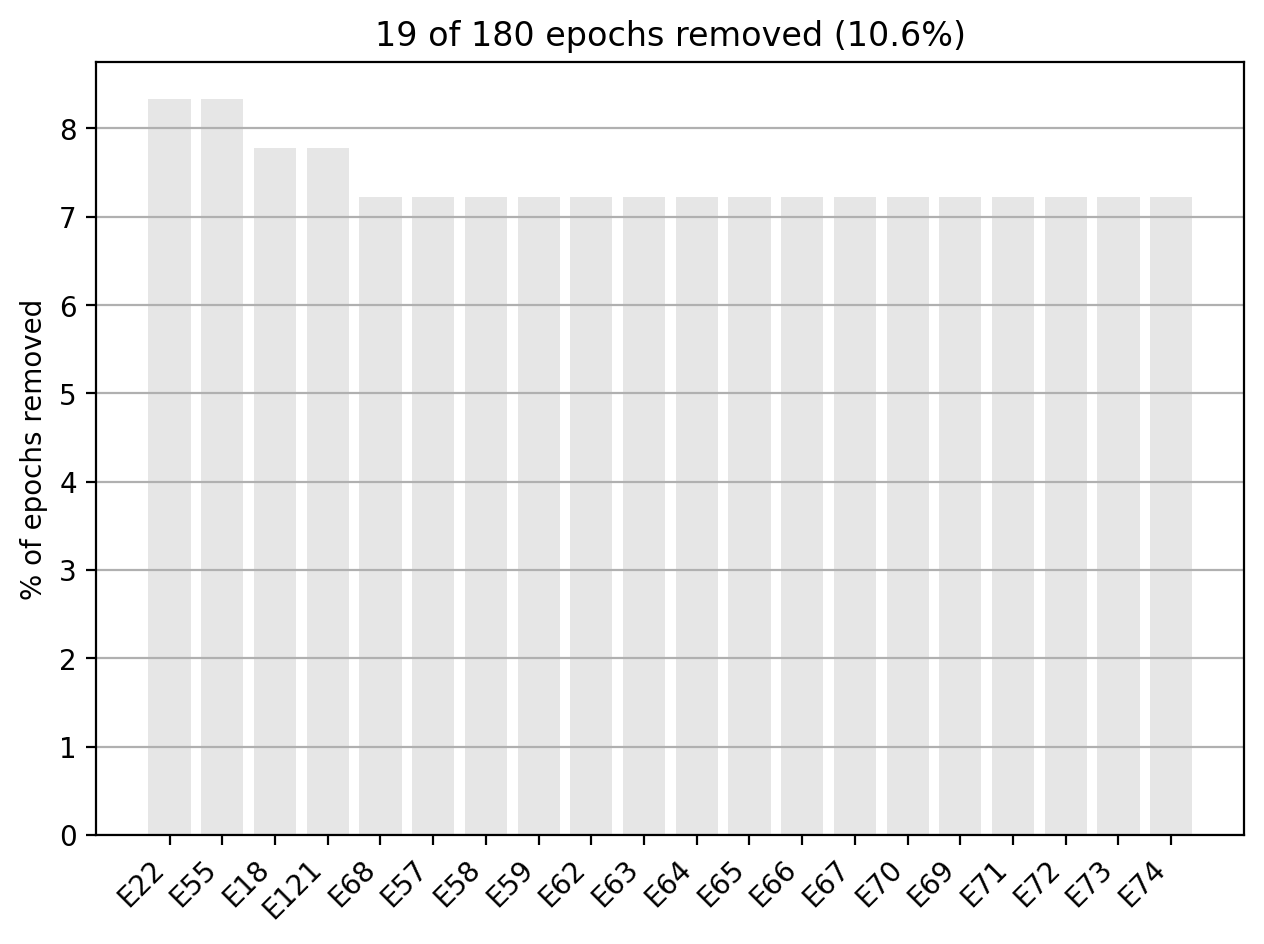

In [89]:
epochs_clean = epochs.copy().load_data()
epochs_clean.drop_bad({'eeg':1000*1e-6})
epochs_clean.plot_drop_log()

In [90]:
epochs_clean

<Epochs |  161 events (all good), 0 - 9.996 sec, baseline off, ~365.6 MB, data loaded,
 '1': 161>

Remove epochs of bad quality remaining

Opening epochs-browser...


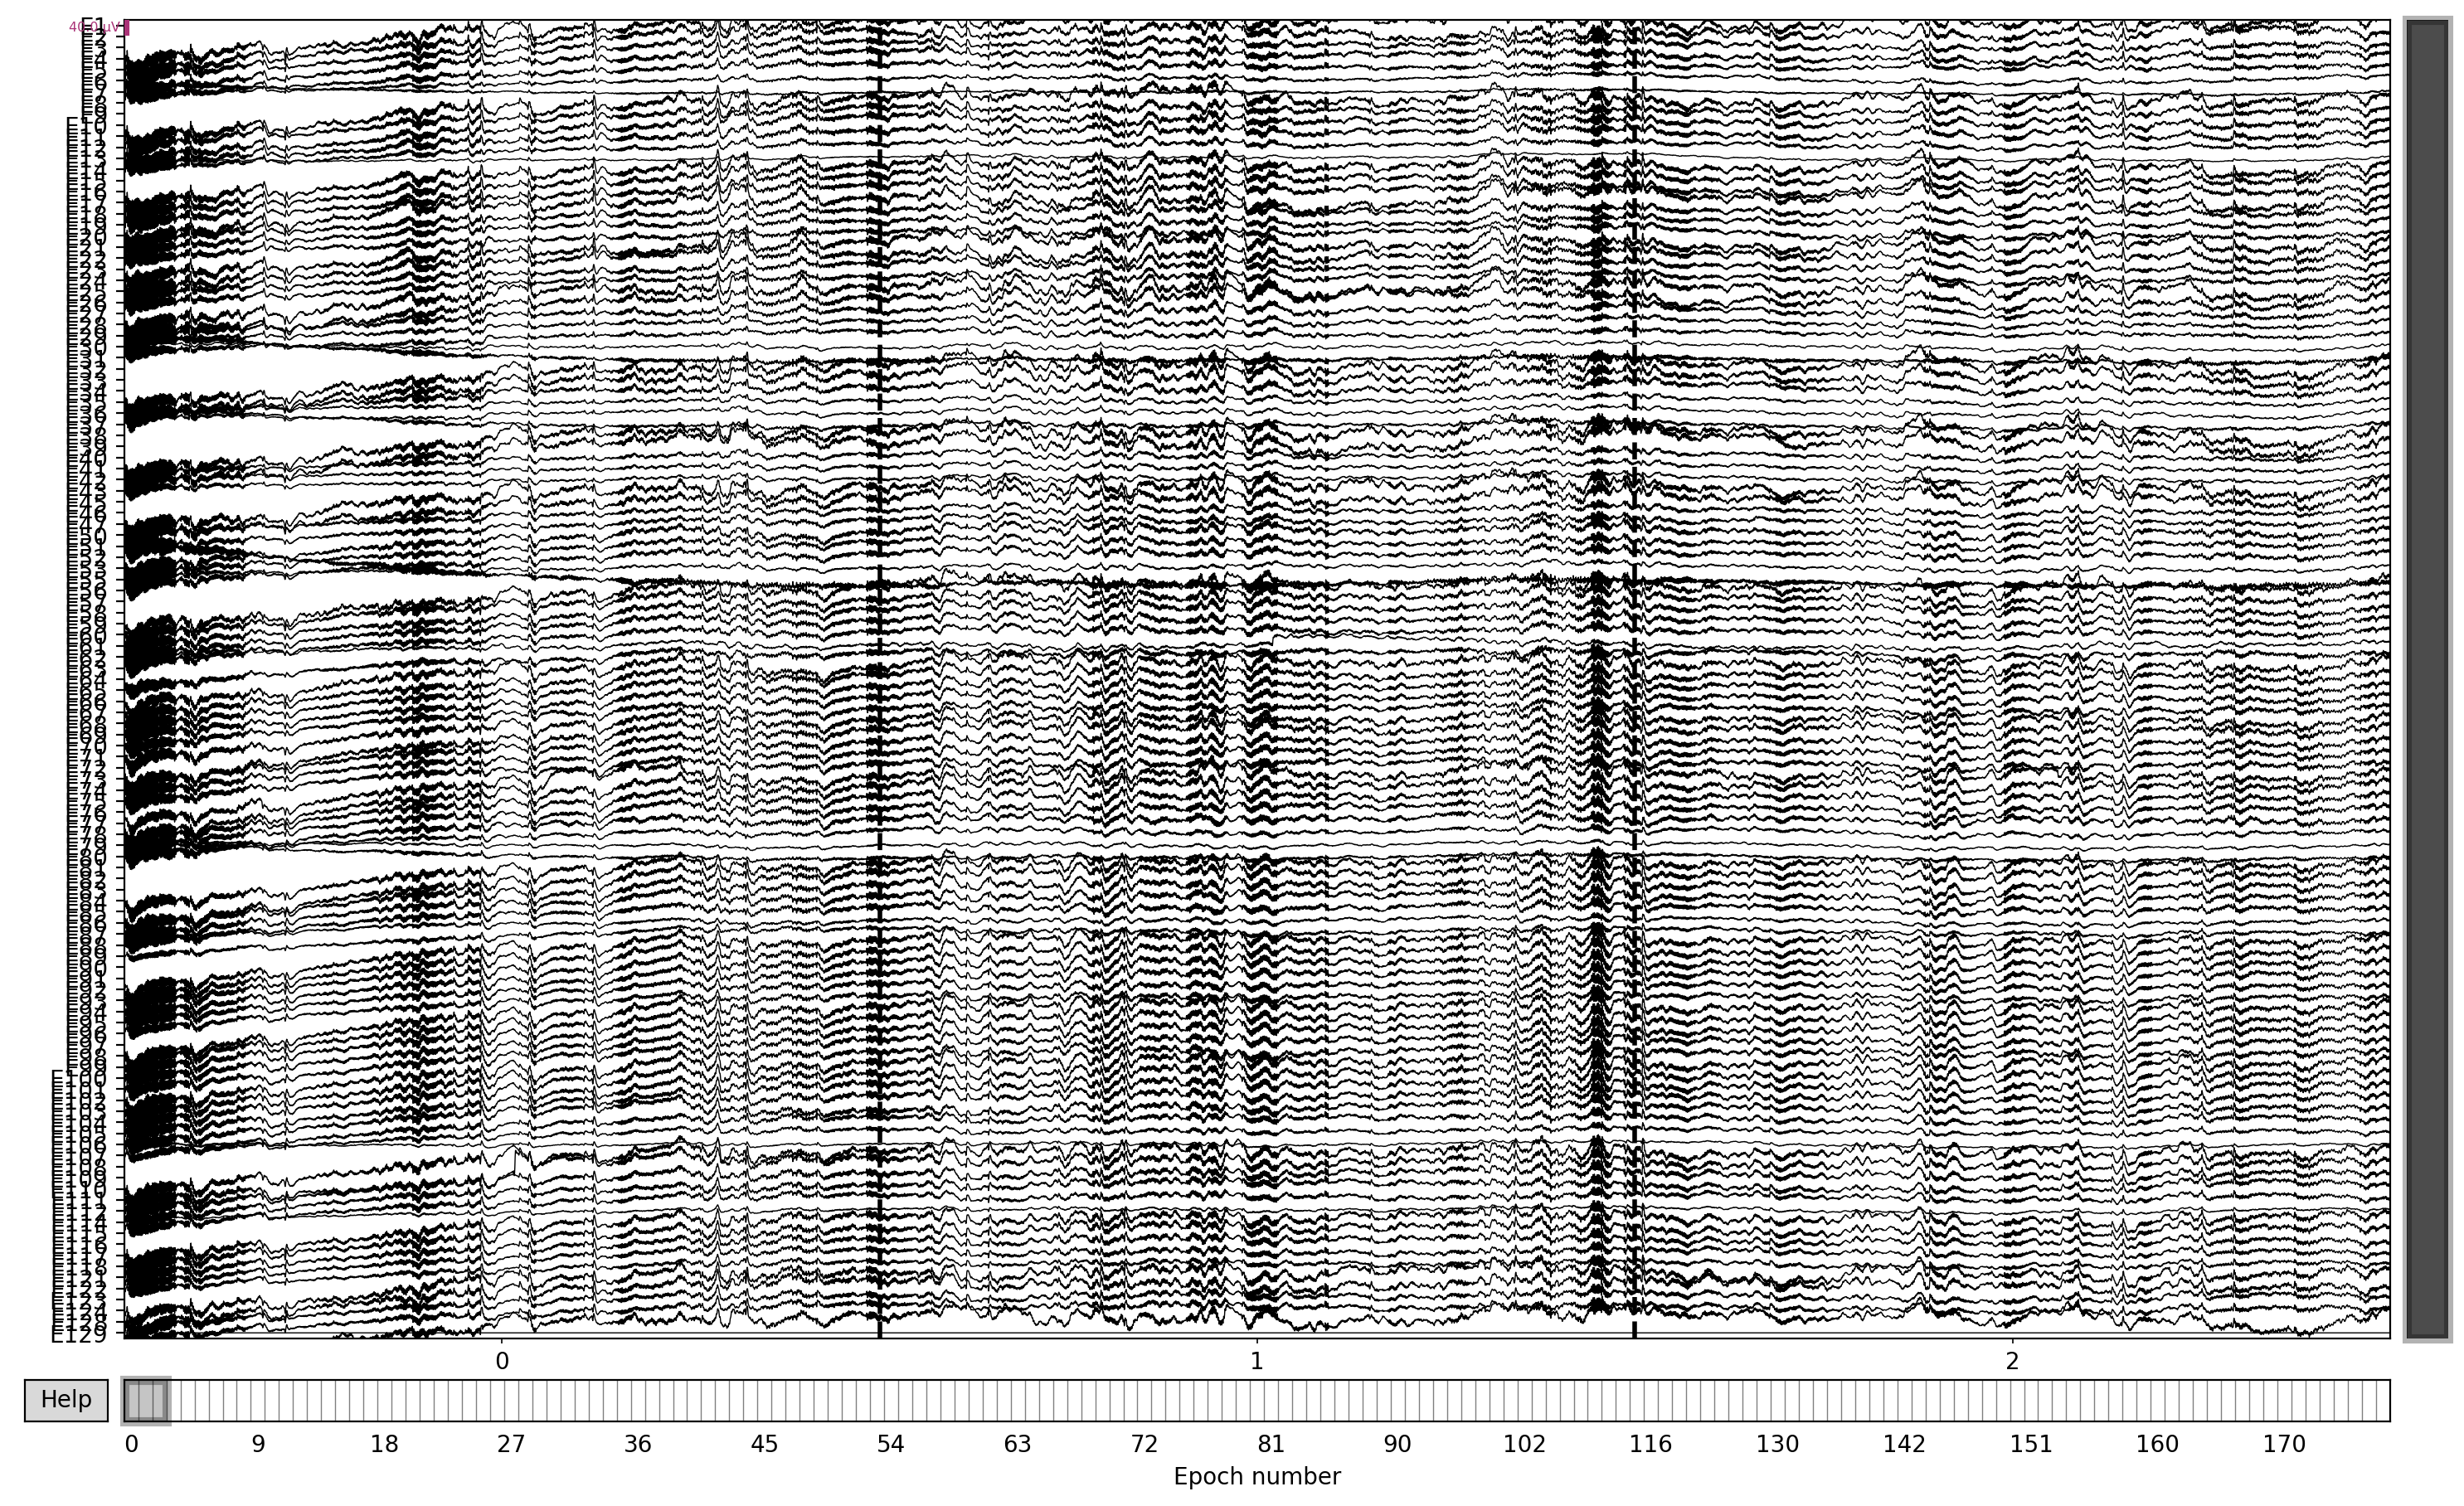

Closing epochs-browser...
Dropped 12 epochs: 0, 9, 10, 19, 24, 32, 33, 52, 53, 57, 58, 102
The following epochs were marked as bad and are dropped:
[0, 9, 10, 19, 24, 32, 33, 52, 53, 57, 58, 105]
Channels marked as bad:
none


In [92]:
epochs_clean.plot(title='bad_epochs_remaining', n_epochs=3, n_channels=120, scalings=20e-6)

In [93]:
epochs_clean

<Epochs |  149 events (all good), 0 - 9.996 sec, baseline off, ~338.4 MB, data loaded,
 '1': 149>

In [ ]:
#epochs_clean.plot(n_epochs=3, n_channels=100, scalings=20e-6)

Closing epochs-browser...
Dropped 0 epochs: 
The following epochs were marked as bad and are dropped:
[0]
Channels marked as bad:
none
    Using multitaper spectrum estimation with 7 DPSS windows


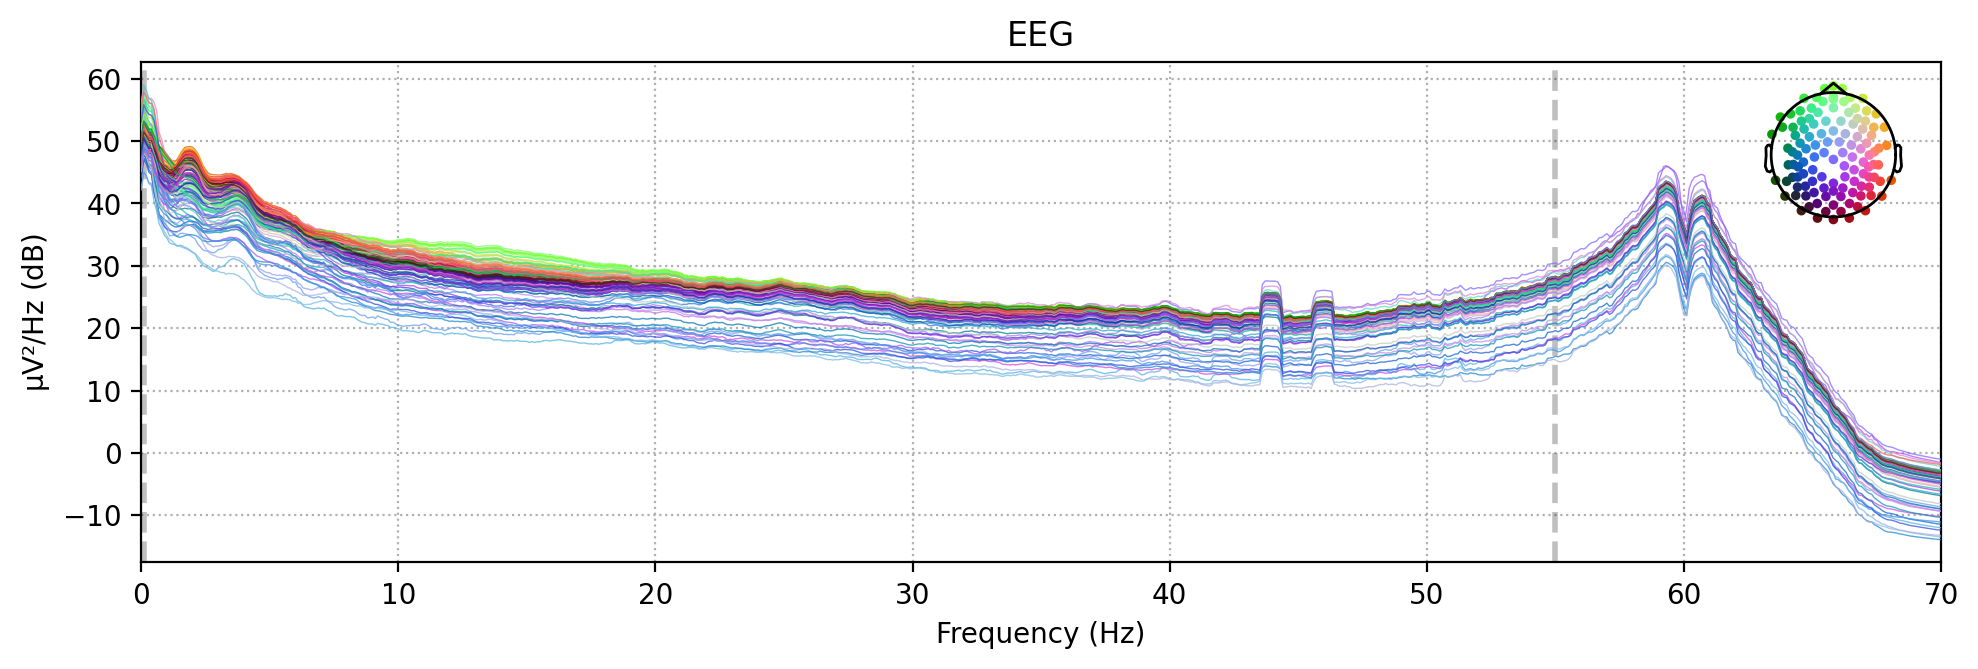

In [94]:
%matplotlib qt
epochs_clean.plot_psd(fmax=70, exclude = ['E129'])
#if not os.path.exists('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task)) :
#    os.makedirs('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task))
#plt.savefig('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_epochs_filtered.png'.format(ID,session,task,ID,session,task))

In [95]:
# save a list of dropped epochs
dropped_epochs =  [n for n, dl in enumerate(epochs_clean.drop_log) if len(dl)]
dropped_epochs = [str(i) for i in dropped_epochs] # need to convert to str to save
# save in a txt
if not os.path.exists('./Preprocessing/sub-{}'.format(ID)) :
    os.makedirs('./Preprocessing/sub-{}'.format(ID))
with open('./Preprocessing/sub-{}/sub-{}_task-{}_dropped_epochs.txt'.format(ID,ID,task), 'w') as outfile:
    outfile.write("\n".join(dropped_epochs))


## Drop additionnal channels afterwards if necessarry

In [ ]:
#Select bad channels on the plot
#epochs_clean.plot(n_epochs=3, n_channels=100, scalings=20e-6)

In [96]:
epochs_clean.info['bads']

[]

In [97]:
epochs_clean = epochs_clean.copy().drop_channels(epochs_clean.info['bads'])

In [36]:
# want to see more data? 
#epochs_clean.plot(n_epochs=3, n_channels=100, scalings=20e-6)

## Average Reference the data

In [98]:
# use the average of all channels as reference
eeg_avg_ref = epochs_clean.set_eeg_reference(ref_channels='average')

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


In [38]:
#eeg_avg_ref.plot(title='Avg ref', n_epochs=3, n_channels=100, scalings=20e-6)

In [39]:
#%matplotlib tk
#eeg_avg_ref.plot_psd(fmax=70)
#if not os.path.exists('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task)) :
#    os.makedirs('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}'.format(ID,session,task))
#plt.savefig('./out_figures2/coma_tacs/sub-{}/ses-{}/task-{}/sub-{}_ses-{}_task-{}_PSD_avg_ref.png'.format(ID,session,task,ID,session,task))

## Remove Non-Brain Electrodes 

In [99]:
non_brain_el = ['E127', 'E126', 'E17', 'E21', 'E14', 'E25', 'E8', 'E128', 'E125', 'E43', 'E120', 'E48', 
                'E119', 'E49', 'E113', 'E81', 'E73', 'E88', 'E68', 'E94', 'E63', 'E99', 'E56', 'E107' ]

#only add non-brain channels if not already part of noisy channels
for e in non_brain_el: 
    if e in eeg_avg_ref.info['ch_names']:
        if e not in marked_bad :
            eeg_avg_ref.info['bads'].append(e)
    


In [100]:
print(eeg_avg_ref.info['bads'])

['E17', 'E21', 'E14', 'E25', 'E8', 'E128', 'E43', 'E81', 'E73', 'E88', 'E68', 'E94', 'E63', 'E99', 'E56', 'E107']


In [101]:
# remove non-brain channels
eeg_brainonly = eeg_avg_ref.copy().drop_channels(eeg_avg_ref.info['bads'])

## Verify removal

In [43]:
#eeg_brainonly.plot(title='brain only', n_epochs=3, n_channels=100, scalings=20e-6)

In [102]:
eeg_brainonly= eeg_brainonly.copy().drop_channels(eeg_brainonly.info['bads'])

Verify psd

In [103]:
%matplotlib qt
eeg_brainonly.plot_psd(fmax=70)
plt.savefig('./Preprocessing/sub-{}/sub-{}_task-{}_PSD_brainonly.png'.format(ID,ID,task))


    Using multitaper spectrum estimation with 7 DPSS windows


## Save final brain data

In [104]:
if not os.path.exists(f'./DATA/{output}/sub-{ID}/eeg/') :
    os.makedirs(f'./DATA/{output}/sub-{ID}/eeg/')

eeg_brainonly.save(f"./DATA/{output}/sub-{ID}/eeg/sub-{ID}_task-{task}_epoch_eeg.fif", overwrite=True)
#ici changer pour le sauver dans derivatives, dossier clean (avec un readme expliquant le cleaning) et le fichier sous le bids format


/var/folders/jt/1njpx4d93pn5y3nd0p7l5hwr0000gn/T/ipykernel_3882/182155578.py:4: RuntimeWarning: This filename (./DATA/continuous_derivative_NET-ICU/sub-022MW/eeg/sub-022MW_task-Turn1_epoch_eeg.fif) does not conform to MNE naming conventions. All epochs files should end with -epo.fif, -epo.fif.gz, _epo.fif or _epo.fif.gz
  eeg_brainonly.save(f"./DATA/{output}/sub-{ID}/eeg/sub-{ID}_task-{task}_epoch_eeg.fif", overwrite=True)
